In [1]:
import torch
import transformers
from torch import nn
import torch.nn.functional as F
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

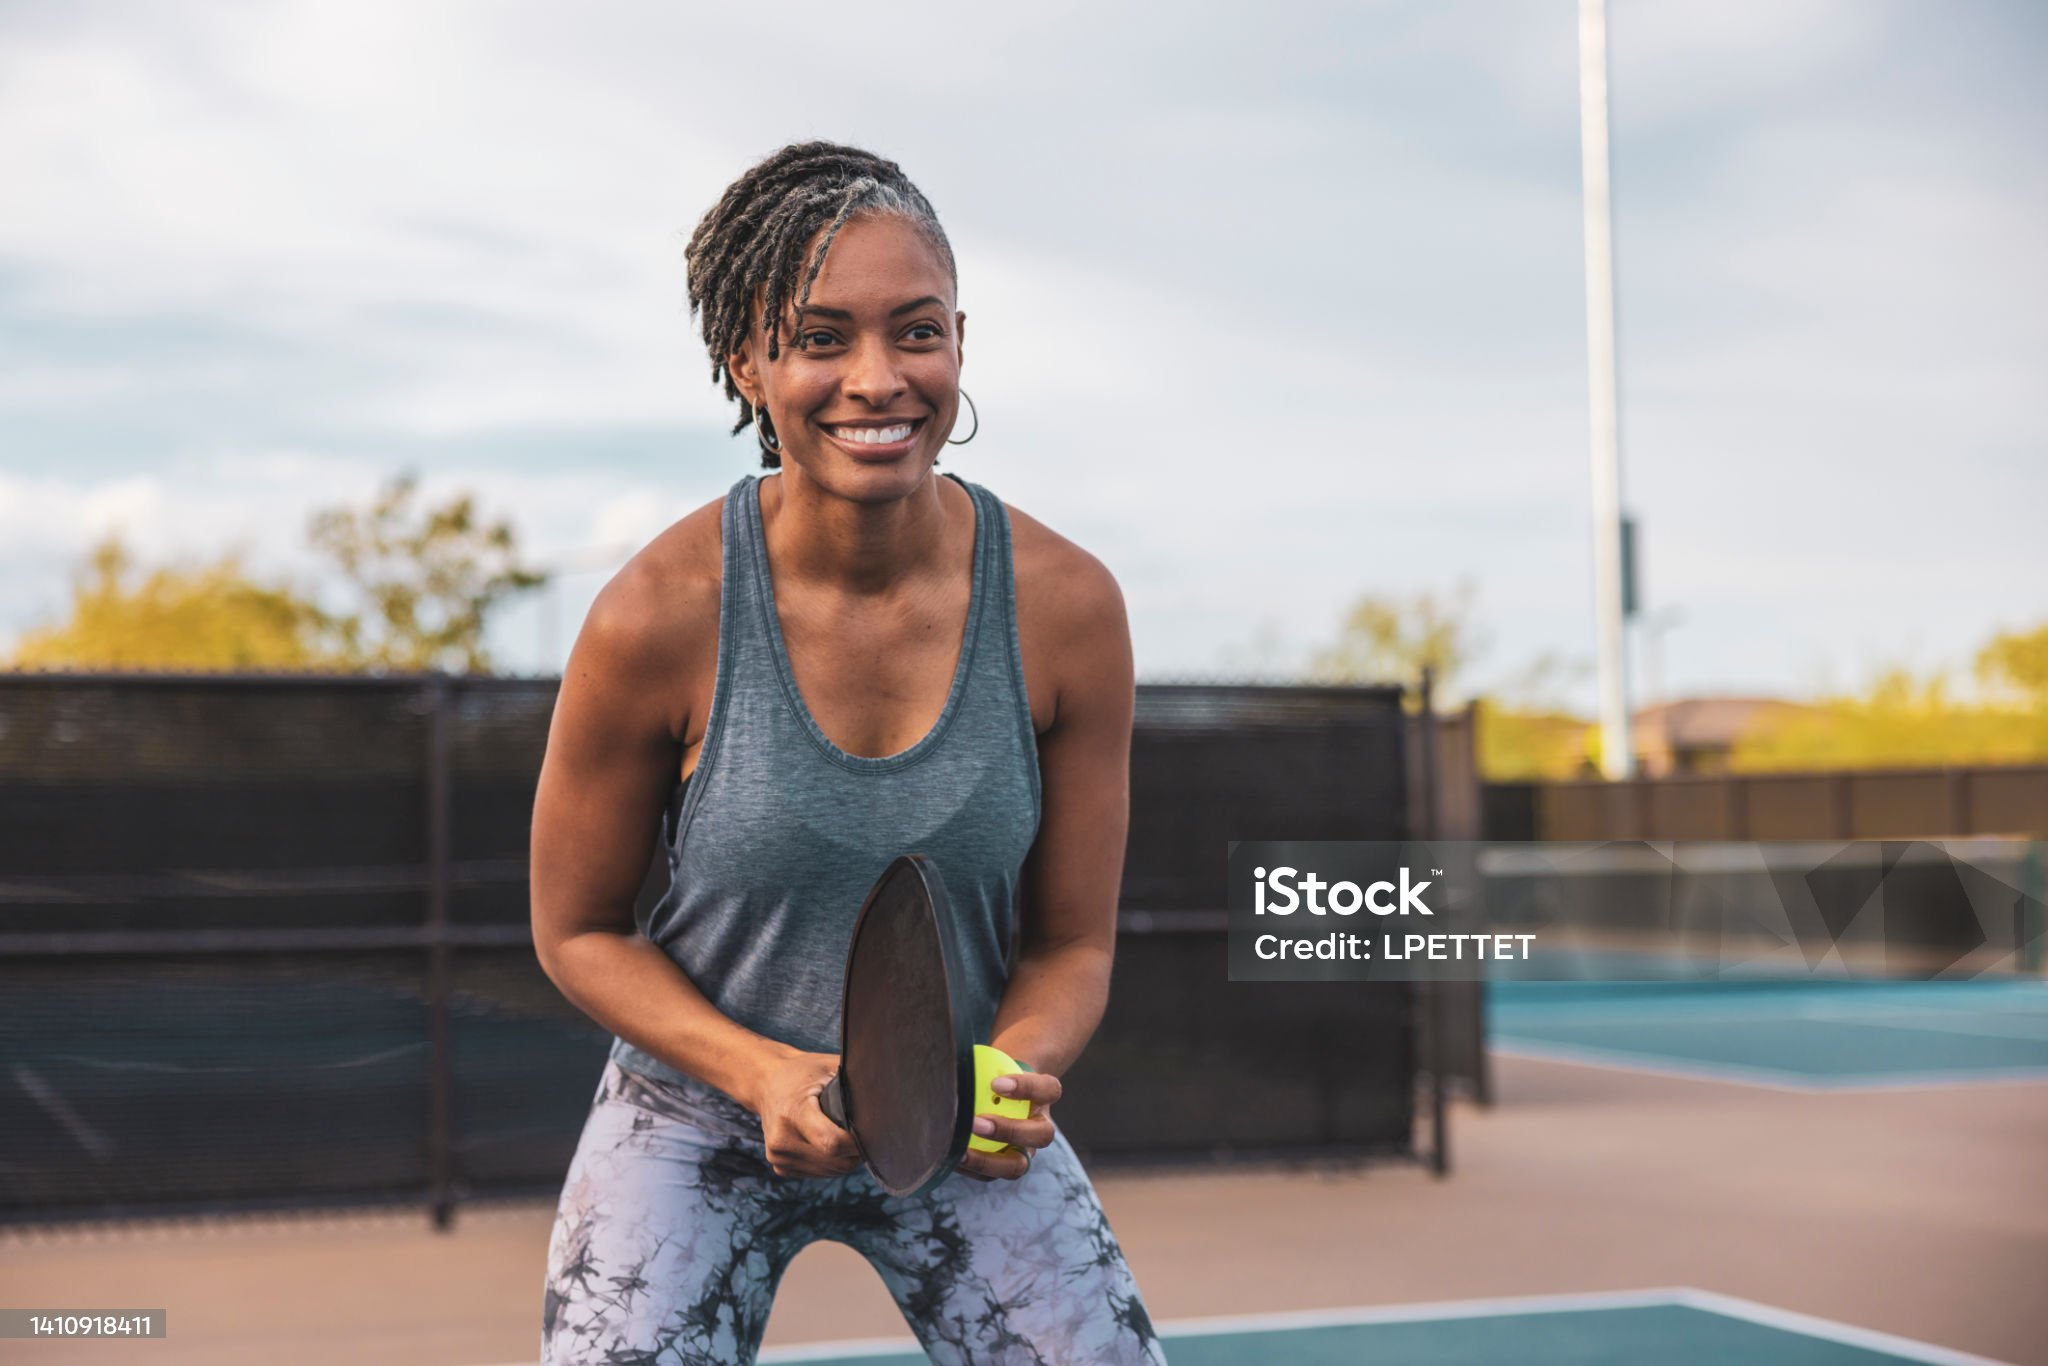

In [3]:
from PIL import Image
import requests

a = requests.get('https://media.istockphoto.com/id/1410918411/photo/pickleball.jpg?s=2048x2048&w=is&k=20&c=G34XLOfbNDu9SytUq5rxSJChjkr2c_ii11W6M9ZGIBc=', stream=True)
image = Image.open(a.raw)
image

In [4]:
import numpy as np
image = np.array(image)

In [5]:
gen_text = tokenizer.decode(model.generate(pixel_values  = image_processor(image, return_tensors="pt").to(device).pixel_values).cpu()[0], skip_special_tokens=True)
gen_text

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
c:\Users\CSE IIT BHILAI\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
c:\Users\CSE IIT BHILAI\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attentio

'a young man is playing tennis on a court '

In [6]:
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
)
import os
if not os.path.exists('IndicTransToolkit'):
    os.system('git clone https://github.com/VarunGumma/IndicTransToolkit')
    os.system('cd IndicTransToolkit && python3 -m pip install --editable ./')
!pip install indic-nlp-library sacremoses
from processor import IndicProcessor


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ai4bharat/indictrans2-en-indic-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True).to(DEVICE)

ip = IndicProcessor(inference=True)

input_sentences = [
    gen_text
]

src_lang, tgt_lang = "eng_Latn", "hin_Deva"

batch = ip.preprocess_batch(
    input_sentences,
    src_lang=src_lang,
    tgt_lang=tgt_lang,
)


# Tokenize the sentences and generate input encodings
inputs = tokenizer(
    batch,
    truncation=True,
    padding="longest",
    return_tensors="pt",
    return_attention_mask=True,
).to(DEVICE)

# Generate translations using the model
with torch.no_grad():
    generated_tokens = model.generate(
        **inputs,
        use_cache=True,
        min_length=0,
        max_length=256,
        num_beams=5,
        num_return_sequences=1,
    )

# Decode the generated tokens into text
with tokenizer.as_target_tokenizer():
    generated_tokens = tokenizer.batch_decode(
        generated_tokens.detach().cpu().tolist(),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

# Postprocess the translations, including entity replacement
translations = ip.postprocess_batch(generated_tokens, lang=tgt_lang)

for input_sentence, translation in zip(input_sentences, translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
d:\MiniProject\IndicTransTokenizer-20241117T093615Z-001\IndicTransTokenizer\IndicTransTokenizer\processor.py:329: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s+", " ", text).replace(">/", ">").replace("]/", "]")


tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

c:\Users\CSE IIT BHILAI\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\CSE IIT BHILAI\.cache\huggingface\hub\models--ai4bharat--indictrans2-en-indic-1B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenization_indictrans.py:   0%|          | 0.00/8.10k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dict.SRC.json:   0%|          | 0.00/645k [00:00<?, ?B/s]

dict.TGT.json:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

model.SRC:   0%|          | 0.00/759k [00:00<?, ?B/s]

model.TGT:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

eng_Latn: a young man is playing tennis on a court 
hin_Deva: एक युवक कोर्ट पर टेनिस खेल रहा है 


c:\Users\CSE IIT BHILAI\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [7]:
from transformers import pipeline
from IPython.display import Audio, display

pipe = pipeline("text-to-speech", model="suno/bark-small", device=DEVICE)
output = pipe(translation)
Audio(output["audio"], rate=output["sampling_rate"])

config.json:   0%|          | 0.00/8.80k [00:00<?, ?B/s]

c:\Users\CSE IIT BHILAI\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\CSE IIT BHILAI\.cache\huggingface\hub\models--suno--bark-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

c:\Users\CSE IIT BHILAI\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\encodec\modeling_encodec.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


generation_config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]